<a href="https://colab.research.google.com/github/ekity1002/PyOptBook-memo/blob/main/Python%E3%81%A7%E3%81%AF%E3%81%98%E3%82%81%E3%82%8B%E6%95%B0%E7%90%86%E6%9C%80%E9%81%A9%E5%8C%96_4_6%E7%AB%A0%E3%83%A1%E3%83%A2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! git clone https://github.com/ohmsha/PyOptBook.git
! cd PyOptBook; pip install -r requirements.txt

Cloning into 'PyOptBook'...
remote: Enumerating objects: 187, done.
remote: Counting objects: 100% (111/111), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 187 (delta 71), reused 61 (delta 41), pack-reused 76
Receiving objects: 100% (187/187), 2.25 MiB | 12.66 MiB/s, done.
Resolving deltas: 100% (88/88), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 14.3 MB 10.5 MB/s 
     |████████████████████████████████| 121 kB 56.0 MB/s 
     |████████████████████████████████| 1.6 MB 62.3 MB/s 
     |████████████████████████████████| 83 kB 699 kB/s 


# 4章　施策クーポン配布最適化
* 決定事項：どのユーザーにどのクーポンを配れば、来店客数を最大化できるか。
* クーポン：３種類。
* ユーザーはセグメントに分かれる。今後のデータ収集のために、それぞれのクーポンを各セグメントの10%以上の会員に送付する
* 消費する予算に上限を考える。
  * 会員の予算消費額の期待値の合計が、100万以内になるように制限

In [2]:
import pandas as pd
cust_df = pd.read_csv('/content/PyOptBook/4.coupon/customers.csv')
prob_df = pd.read_csv('/content/PyOptBook/4.coupon/visit_probability.csv')

In [3]:
cust_df.shape

(5000, 3)

In [4]:
cust_df.head()

,customer_id,age_cat,freq_cat
0,1,age20~34,freq2
1,2,age35~49,freq0
2,3,age35~49,freq0
3,4,age~19,freq0
4,5,age35~49,freq0


In [5]:
cust_df.age_cat.unique()

array(['age20~34', 'age35~49', 'age~19', 'age50~'], dtype=object)

In [6]:
cust_df.freq_cat.unique()

array(['freq2', 'freq0', 'freq1', 'freq3~'], dtype=object)

In [12]:
# 年代、来店頻度ごとの客数の可視化
import seaborn as sns
pivot_df = pd.pivot_table(data=cust_df, values='customer_id',columns='freq_cat',index='age_cat' ,aggfunc='count')
pivot_df

freq_cat,freq0,freq1,freq2,freq3~
age_cat,,,,
age20~34,600,450,150,300
age35~49,800,600,200,400
age50~,400,300,100,200
age~19,200,150,50,100


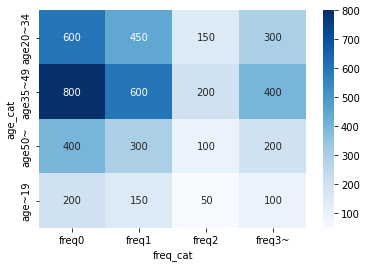

In [14]:
sns.heatmap(pivot_df, annot=True, fmt='d', cmap='Blues')

In [15]:
# 来店率データ
prob_df

,age_cat,freq_cat,segment_id,prob_dm1,prob_dm2,prob_dm3
0,age~19,freq0,1,0.07,0.12,0.29
1,age~19,freq1,2,0.21,0.30,0.58
2,age~19,freq2,3,0.28,0.39,0.74
3,age~19,freq3~,4,0.35,0.45,0.77
4,age20~34,freq0,5,0.11,0.17,0.37
5,age20~34,freq1,6,0.32,0.43,0.72
6,age20~34,freq2,7,0.42,0.55,0.93
7,age20~34,freq3~,8,0.52,0.63,0.94
8,age35~49,freq0,9,0.08,0.14,0.33
9,age35~49,freq1,10,0.25,0.35,0.67


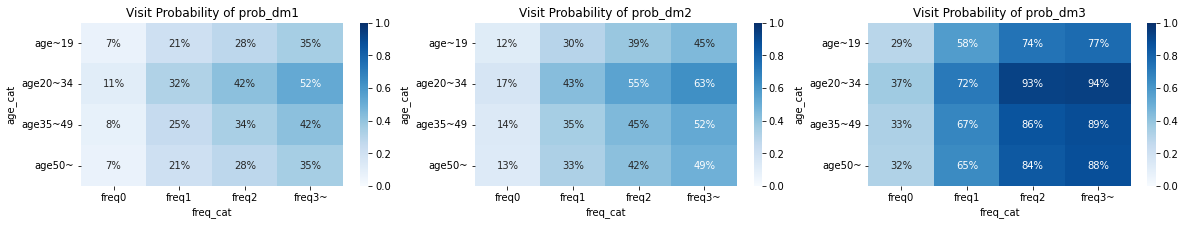

In [19]:
import matplotlib.pyplot as plt
ax = {}
fig, (ax[0], ax[1], ax[2]) = plt.subplots(1,3, figsize=(20,3))
for i, ptn in enumerate(['prob_dm1', 'prob_dm2', 'prob_dm3']):
    prob_pivot_df = pd.pivot_table(data=prob_df, values=ptn, columns='freq_cat', index='age_cat')
    prob_pivot_df = prob_pivot_df.reindex (['age~19','age20~34', 'age35~49', 'age50~'])
    sns.heatmap(prob_pivot_df, vmin=0, vmax=1, annot=True, fmt='.0%', cmap='Blues', ax=ax[i])
    ax[i].set_title(f'Visit Probability of {ptn}')
plt.show()

## モデル作成
* 2つの観点で作成する
  * 会員ひとり一人に対して、どのDMを送付するかを決定するモデル
  * セグメントに対して、どのパターンのメールをどの程度送付するかを決定するモデル

## 制約を考えるときは、一つ一つ条件を追加して動作を確認するとわかりやすい

### 一人ひとりに送付するモデル：個別会員送付モデル

In [20]:
import pulp
prob = pulp.LpProblem(name='prob1', sense=pulp.LpMaximize)

In [21]:
I = cust_df.customer_id.tolist() #会員ID
M = [1,2,3] #DMのタイプ

In [22]:
# 顧客に配られたDMの種類を表す変数を定義する.
 xim = dict()
 for i in I:
     for m in M:
         xim[(i,m)] = pulp.LpVariable(name=f"xim({i},{m})", cat="binary")
len(xim)

15000

In [25]:
# 要件２：会員に対して送付するメールはいずれか１パターン
for i in I:
    prob += pulp.lpSum([xim[i,m] for m in M]) == 1

In [26]:
# 要件３：クーポン付与による来客増加数を最大化
keys = ['age_cat','freq_cat']
cust_prob_df = pd.merge(cust_df, prob_df, on=keys)
cust_prob_df.head()

,customer_id,age_cat,freq_cat,segment_id,prob_dm1,prob_dm2,prob_dm3
0,1,age20~34,freq2,7,0.42,0.55,0.93
1,199,age20~34,freq2,7,0.42,0.55,0.93
2,200,age20~34,freq2,7,0.42,0.55,0.93
3,255,age20~34,freq2,7,0.42,0.55,0.93
4,269,age20~34,freq2,7,0.42,0.55,0.93


In [31]:
cust_prob_var_df = cust_prob_df.rename(columns={'prob_dm1':1, 'prob_dm2':2,'prob_dm3':3}).melt(
    id_vars=['customer_id'], #縦持ちするときのIDカラム名
     value_vars=[1,2,3],# value に使用するカラム名 これとIDカラムについて縦持ちになる
      var_name='dm', # 変数 カラム名の指定
       value_name='prob') #value カラム名の指定
cust_prob_var_df

,customer_id,dm,prob
0,1,1,0.42
1,199,1,0.42
2,200,1,0.42
3,255,1,0.42
4,269,1,0.42
...,...,...,...
14995,4474,3,0.74
14996,4596,3,0.74
14997,4720,3,0.74
14998,4910,3,0.74


In [37]:
Pim = cust_prob_var_df.set_index(['customer_id','dm'])['prob'].to_dict()
#Pim

In [38]:
Pim[1,1] #ユーザーID１，DMタイプ１のときの来店率  

0.42

In [39]:
# クーポン付与による来客増加率を最大化
# (クーポン配布時の来店率 - クーポン配布しないときの来店率) * その客がクーポンを配られたかの変数
# を最大化
# クーポン配らない(m=1 の場合)は期待値に関係ないので変数を作成しないようにする
prob += pulp.lpSum([Pim[i,m] - Pim[i, 1] * xim[i,m] for i in I for m in [2,3]])

In [44]:
# 要件４: 予算の消費期待値の合計は100万以下
# クーポン配らない(m=1 の場合)は期待値に関係ないので変数を作成しないようにする
Cm = {1:0, 2:1000, 3:2000}
prob += pulp.lpSum(xim[i,m] * Pim[i,m] * Cm[m] for i in I for m in [2,3]) <= 1000000

In [45]:
# それぞれのセグメントに属する会員数N
# 会員iがセグメントsに属するかを表す変数 z_is を用意する
S = prob_df['segment_id'].tolist()
S

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

In [47]:
# セグメントごとの会員数
Ns = cust_prob_df.groupby(['segment_id'])['customer_id'].count().to_dict()
Ns

{1: 200,
 2: 150,
 3: 50,
 4: 100,
 5: 600,
 6: 450,
 7: 150,
 8: 300,
 9: 800,
 10: 600,
 11: 200,
 12: 400,
 13: 400,
 14: 300,
 15: 100,
 16: 200}

In [ ]:
#cust_prob_df

In [ ]:
# 会員->segment
Si = cust_prob_df.set_index('customer_id')['segment_id'].to_dict()
Si

In [50]:
# Σz_is*x_im / Ns >= 0.1 が、各セグメントに対して成り立つことを加える
for s in S:
    for m in M:
        prob += pulp.lpSum([xim[i,m] for i in I if Si[i] == s]) >= 0.1 * Ns[s]

In [51]:
status = prob.solve()
print(status)

1


In [54]:
pulp.LpStatus[status]

'Optimal'

In [64]:
#[[xim[i,m].value() for m in M]  for i in I]
xim[1,3].value()

15.0

In [ ]:
# セグメントに付与されたクーポン確認
# なんか変?
send_dm_df = pd.DataFrame([[xim[i,m].value() for m in M]  for i in I], columns=['send_dm1','send_dm2','send_dm3'])
send_dm_df

In [65]:
cust_send_df = pd.concat([cust_df[['customer_id', 'age_cat', 'freq_cat']], send_dm_df], axis=1)
cust_send_df.head()

,customer_id,age_cat,freq_cat,send_dm1,send_dm2,send_dm3
0,1,age20~34,freq2,-29.0,15.0,15.0
1,2,age35~49,freq0,0.0,1.0,0.0
2,3,age35~49,freq0,1.0,0.0,0.0
3,4,age~19,freq0,1.0,0.0,0.0
4,5,age35~49,freq0,1.0,0.0,0.0


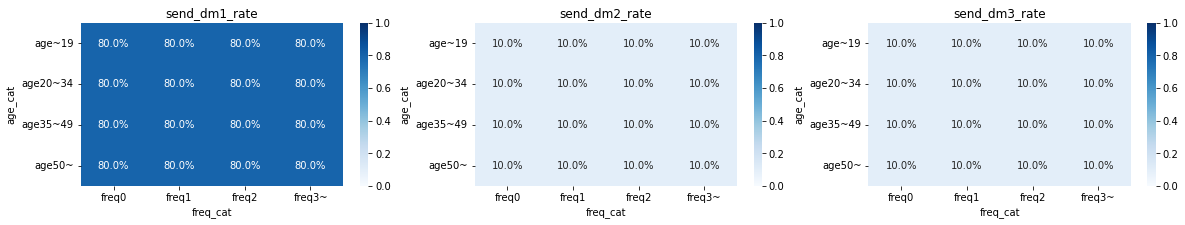

In [66]:
# 各セグメントに対するそれぞれのダイレクトメールの送付率
ax = {}
fig, (ax[0], ax[1], ax[2]) = plt.subplots(1,3, figsize=(20,3))
for i, ptn in enumerate(['send_dm1', 'send_dm2', 'send_dm3']):
    cust_send_pivot_df = pd.pivot_table(data=cust_send_df, values=ptn, columns='freq_cat', index='age_cat', aggfunc='mean')
    cust_send_pivot_df = cust_send_pivot_df.reindex(['age~19', 'age20~34', 'age35~49', 'age50~'])
    sns.heatmap(cust_send_pivot_df, annot=True, fmt='.1%', cmap='Blues', vmin=0, vmax=1, ax=ax[i])
    ax[i].set_title(f'{ptn}_rate')
plt.show()

## セグメント送付モデル

In [72]:
problem = pulp.LpProblem('prob2', sense=pulp.LpMaximize)

In [73]:
# （1）各会員に対してどのパターンのダイレクトメールを送付するかを決定
xsm = {}
# ［0,1］の変数を宣言
for s in S:
    for m in M:
        xsm[s,m] = pulp.LpVariable(name=f'xsm({s},{m})',
        lowBound=0, upBound=1, cat='Continuous') # [0,1] の連続変数！！
len(xsm)

48

In [74]:
# （2）各会員に対して送付するダイレクトメールはいずれか1パターン
for s in S:
    problem += pulp.lpSum(xsm[s,m] for m in M) == 1

In [75]:
prob_ver_df = prob_df.rename(columns={'prob_dm1': 1,'prob_dm2': 2, 'prob_dm3': 3})\
.melt(id_vars=['segment_id'], value_vars=[1,2,3], var_name='dm', value_name='prob')
Psm = prob_ver_df.set_index(['segment_id','dm'])['prob'].to_dict()

In [76]:
# （3）クーポン付与による来客増加数を最大化
problem += pulp.lpSum(Ns[s] * (Psm[s,m] - Psm[s,1]) * xsm[s,m] for s in S for m in [2,3])

In [77]:
# （4）会員の予算消費期待値の合計は100万円以下
problem += pulp.lpSum(Cm[m] * Ns[s] * Psm[s,m] * xsm[s,m] for s in S for m in [2,3]) <= 1000000

In [78]:
# （5）各パターンのダイレクトメールをそれぞれのセグメントに属する会員数の10%以上に送付
for s in S:
    for m in M:
        problem += xsm[s,m] >= 0.1

In [80]:
import time
time_start = time.time()
status = problem.solve()
time_stop = time.time()
print(f'ステータス:{pulp.LpStatus[status]}')
print(f'目的関数値:{pulp.value(problem.objective):.4}')
print(f'計算時間:{(time_stop - time_start):.3}(秒)')

ステータス:Optimal
目的関数値:326.1
計算時間:0.0406(秒)


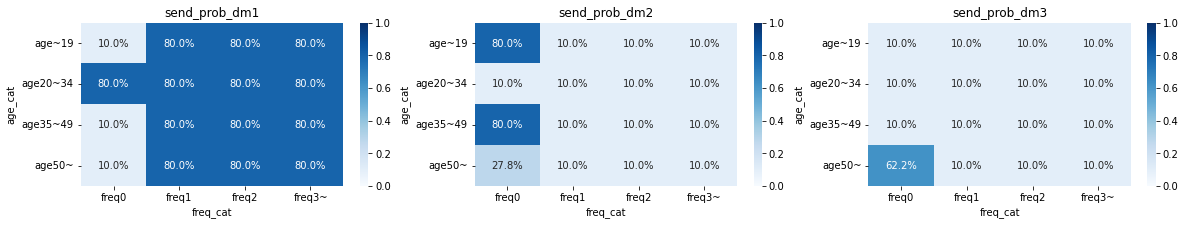

In [81]:
send_dm_df = pd.DataFrame([[xsm[s,m].value() for m in M] for s in S], columns=['send_prob_dm1', 'send_prob_dm2','send_prob_dm3'])
seg_send_df = pd.concat([prob_df[['segment_id', 'age_cat', 'freq_cat']], send_dm_df], axis=1)
# 各セグメントに対するそれぞれのダイレクトメールの送付率
ax = {}
fig, (ax[0], ax[1], ax[2]) = plt.subplots(1,3, figsize=(20,3))
for i, ptn in enumerate(['send_prob_dm1', 'send_prob_dm2', 'send_prob_dm3']):
    seg_send_pivot_df = pd.pivot_table(data=seg_send_df,values=ptn, columns='freq_cat', index='age_cat', aggfunc='mean')
    seg_send_pivot_df = seg_send_pivot_df.reindex(['age~19', 'age20~34', 'age35~49', 'age50~'])
    sns.heatmap(seg_send_pivot_df, annot=True, fmt='.1%', cmap='Blues', vmin=0, vmax=1, ax=ax[i])
    ax[i].set_title(f'{ptn}')
plt.show()

## セグメントの送付率も均等になるように考慮したモデルも作成する

In [82]:
# 数理モデルのインスタンス作成
problem = pulp.LpProblem(name='DiscountCouponProblem3', sense=pulp.LpMaximize)

In [83]:
# （1）各セグメントへのそれぞれパターンのダイレクトメールの送付率の下限値と各会員に対してどのダイレクトメールを送付するかを決定
# 会員に対してどのダイレクトメールを送付するか
xsm = {}
# ［0,1］の変数を宣言
for s in S:
    for m in M:
        xsm[s,m] = pulp.LpVariable(name=f'xsm({s},{m})', lowBound=0, upBound=1, cat='Continuous')
# 各セグメントへのそれぞれパターンのダイレクトメールの送付率の下限値
y = pulp.LpVariable(name='y', lowBound=0, upBound=1, cat='Continuous')

In [84]:
# （3）各セグメントへのそれぞれパターンのダイレクトメールの送付率の下限値を最大化
problem += y

In [85]:
# （5）各パターンのダイレクトメールを設定した送付率の下限値以上に送付
for s in S:
    for m in M:
        problem += xsm[s,m] >= y

In [86]:
# （2）各会員に対して送付するダイレクトメールはいずれか1パターン
for s in S:
    problem += pulp.lpSum(xsm[s,m] for m in M) == 1
# （4）会員の予算消費期待値の合計は100万円以下
problem += pulp.lpSum(Cm[m] * Ns[s] * Psm[s,m] * xsm[s,m] for s in S for m in [2,3]) <= 1000000

In [87]:
status = problem.solve()
max_lowerbound = pulp.value(problem.objective)
print(f'ステータス: {pulp.LpStatus[status]}, 目的関数値:{max_lowerbound :.3}')

ステータス: Optimal, 目的関数値:0.131


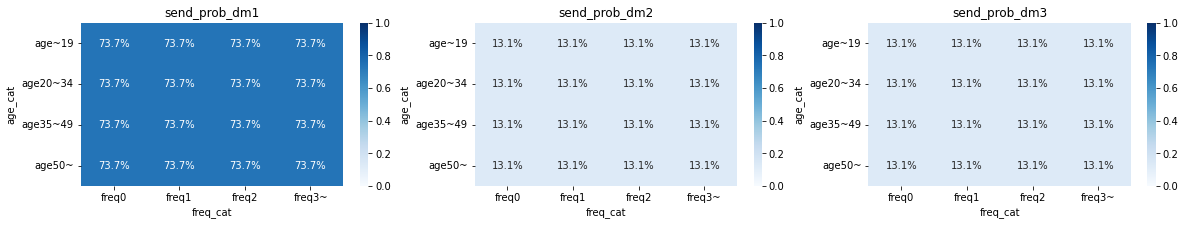

In [88]:
send_dm_df = pd.DataFrame([[xsm[s,m].value() for m in M]for s in S], columns=['send_prob_dm1', 'send_prob_dm2','send_prob_dm3'])
seg_send_df = pd.concat([prob_df[['segment_id', 'age_cat', 'freq_cat']], send_dm_df], axis=1)
ax = {}
fig, (ax[0], ax[1], ax[2]) = plt.subplots(1,3, figsize=(20,3))
for i, ptn in enumerate(['send_prob_dm1', 'send_prob_dm2', 'send_prob_dm3']):
    seg_send_pivot_df = pd.pivot_table(data=seg_send_df,values=ptn, columns='freq_cat',index='age_cat', aggfunc='mean')
    seg_send_pivot_df = seg_send_pivot_df.reindex(['age~19', 'age20~34', 'age35~49', 'age50~'])
    sns.heatmap(seg_send_pivot_df, annot=True, fmt='.1%', cmap='Blues', vmin=0, vmax=1, ax=ax[i])
    ax[i].set_title(f'{ptn}')
plt.show()

## 投資対効果の評価
* 予算の上限を変化させて、来店数一人あたりの費用（CPA）の変化を見る
* 最適な予算の値を考えることができる

In [89]:
cost_list = []
cpa_list = []
inc_action_list = []

In [90]:

print('ステータス, キャンペーン費用, 来客増加数, CPA')
# 761850 は、送付率の下限を１０％とした場合の、キャンペーン予算の最小値
# これも最適化で求められる。
for cost in range(761850, 3000000, 100000):
    # 数理モデルのインスタンス作成
    problem = pulp.LpProblem(name='DiscountCouponProblem2', sense=pulp.LpMaximize)
    # （1）各会員に対してどのダイレクトメールを送付するかを決定
    xsm = {}
    # [0,1]の変数を宣言
    for s in S:
        for m in M:
            xsm[s,m] = pulp.LpVariable(name=f'xsm({s},{m})', lowBound=0, upBound=1, cat='Continuous')
    # （2）各会員に対して送付するダイレクトメールはいずれか1パターン
    for s in S:
        problem += pulp.lpSum(xsm[s,m] for m in M) == 1
    # （3）クーポン付与による来客増加数を最大化
    problem += pulp.lpSum(Ns[s] * (Psm[s,m] - Psm[s,1]) * xsm[s,m] for s in S for m in [2,3])
    # （4）会員の予算消費期待値の合計はcost円以下
    problem += pulp.lpSum(Cm[m] * Ns[s] * Psm[s,m] * xsm[s,m] for s in S for m in [2,3]) <= cost
    # （5）各パターンのダイレクトメールを設定した送付率の下限値以上に送付
    for s in S:
        for m in M:
            problem += xsm[s,m] >= 0.1
    status = problem.solve()
    cpa = cost/pulp.value(problem.objective)
    inc_action = pulp.value(problem.objective)
    cost_list.append(cost)
    cpa_list.append(cpa)
    inc_action_list.append(inc_action)
    print(f'{pulp.LpStatus[status]}, {cost}, {inc_action :.4}, {cpa :.5}')

ステータス, キャンペーン費用, 来客増加数, CPA
Optimal, 761850, 229.0, 3326.9
Optimal, 861850, 273.1, 3156.3
Optimal, 961850, 311.9, 3084.0
Optimal, 1061850, 349.1, 3042.0
Optimal, 1161850, 385.8, 3011.8
Optimal, 1261850, 422.3, 2988.0
Optimal, 1361850, 458.8, 2968.0
Optimal, 1461850, 495.2, 2951.8
Optimal, 1561850, 530.5, 2944.2
Optimal, 1661850, 565.6, 2938.4
Optimal, 1761850, 600.7, 2933.2
Optimal, 1861850, 634.2, 2935.9
Optimal, 1961850, 667.3, 2940.2
Optimal, 2061850, 700.2, 2944.5
Optimal, 2161850, 732.5, 2951.4
Optimal, 2261850, 764.1, 2960.1
Optimal, 2361850, 795.5, 2969.2
Optimal, 2461850, 826.8, 2977.5
Optimal, 2561850, 858.1, 2985.3
Optimal, 2661850, 889.5, 2992.6
Optimal, 2761850, 920.8, 2999.3
Optimal, 2861850, 951.7, 3007.1
Optimal, 2961850, 981.9, 3016.4


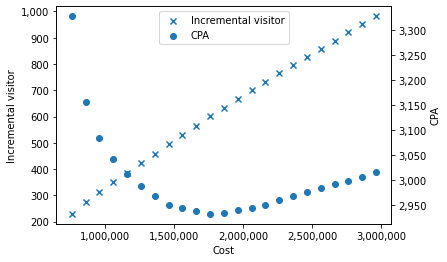

In [91]:
import matplotlib.ticker as ticker
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.scatter(cost_list, inc_action_list, marker='x', label='Incremental visitor')
ax2.scatter(cost_list, cpa_list, label='CPA')
ax1.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x :,.0f}'))
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x :,.0f}'))
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x :,.0f}'))
ax1.set_xlabel('Cost')
ax1.set_ylabel('Incremental visitor')
ax2.set_ylabel('CPA')
reg1, label1 = ax1.get_legend_handles_labels()
reg2, label2 = ax2.get_legend_handles_labels()
ax2.legend(reg1 + reg2, label1 + label2, loc='upper center')
plt.show()

* 一人あたりのCPAが最も安くなる 176万円程度。このあたりが最も費用対効果が高い。
* 費用対効果重視なら予算はこの程度、来店者数を重視するなら予算をかけてCPAを確認する

# まとめ
* 同じ問題でも、複数のモデリングが可能
* モデルの形で問題のときやすさも変わる
* 変数は少なくするほうがよい。
* 連続変数と離散変数なら、連続変数を使ったほうが良い結果になりやすい
* 施策のパラメータを変化させながら、結果を確認するのが大事